# Data Preprocessing

- load_dataset

In [ ]:
from datasets import load_dataset

ds = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Beauty_and_Personal_Care")



- Sample size: 
For this dataset:

Population Size: 23,911,390
Sample Size: 385 (as calculated in this set)
This approach ensures that the sample size is statistically valid for the given confidence level and margin of error.

DatasetDict({
    full: Dataset({
        features: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase'],
        num_rows: 23911390
    })
})
Total number of rows: 23911390
Calculated sample size: 385
Sampled dataset: Dataset({
    features: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase'],
    num_rows: 385
})


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Sample saved to sampled_data.jsonl


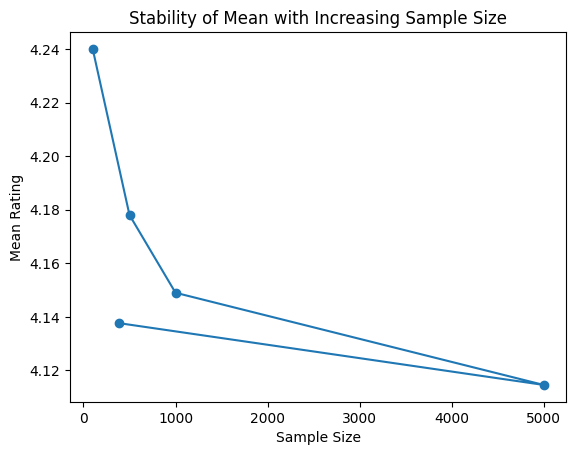

In [ ]:
from datasets import load_dataset
from math import ceil
import matplotlib.pyplot as plt

# Step 1: Load the Dataset
ds = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Beauty_and_Personal_Care")
print(ds)

# Access the 'full' split
split_name = 'full'
population_size = len(ds[split_name])
print(f"Total number of rows: {population_size}")

# Step 2: Calculate Sample Size
def calculate_sample_size(population_size, confidence_level=0.95, margin_of_error=0.05, proportion=0.5):
    z_scores = {0.90: 1.645, 0.95: 1.96, 0.99: 2.576}
    z = z_scores[confidence_level]
    numerator = (z**2) * proportion * (1 - proportion)
    denominator = margin_of_error**2
    sample_size = numerator / denominator
    sample_size = sample_size / (1 + (sample_size - 1) / population_size)  # Adjust for finite population
    return ceil(sample_size)

# Calculate the sample size
sample_size = calculate_sample_size(population_size)
print(f"Calculated sample size: {sample_size}")

# Step 3: Randomly Sample the Dataset
sampled_ds = ds[split_name].shuffle(seed=42).select(range(sample_size))
print(f"Sampled dataset: {sampled_ds}")

# Step 4: Save the Sample
sampled_ds.to_json("sampled_data.jsonl")
print("Sample saved to sampled_data.jsonl")

# Step 5: Evaluate Sample Stability
# Analyze a metric across different sample sizes
sample_sizes = [100, 500, 1000, 5000, sample_size]
means = []

for size in sample_sizes:
    sample = ds[split_name].shuffle(seed=42).select(range(size))
    mean_rating = sum(sample['rating']) / len(sample)  # Replace 'rating' with the actual column
    means.append(mean_rating)

# Plot the stability of the mean
plt.plot(sample_sizes, means, marker='o')
plt.xlabel('Sample Size')
plt.ylabel('Mean Rating')
plt.title('Stability of Mean with Increasing Sample Size')
plt.show()

# Data Preprocessing

#### Removing punctuation, tokenizing text, and removing stopwords from meta review dataset, you can use nltk or spacy

- Loading meta review dataset: Load the imdb dataset using load_dataset from Hugging Face.
- Tokenization: nltk's word_tokenize splits the text into individual words.
- Stopword Removal: Filter out common words like "the", "is", "and", etc.
- Punctuation Removal: Using string.punctuation to eliminate punctuation tokens.

In [ ]:
from datasets import load_dataset
import re
from nltk.corpus import stopwords
import string
import nltk

# Download required NLTK resources
nltk.download('stopwords')

# Load the sampled dataset
ds = load_dataset("json", data_files="sampled_data.jsonl", split="train")

# Prepare stop words and punctuation
stop_words = set(stopwords.words('english'))
punctuation = string.punctuation

def preprocess_text(text):
    """
    Preprocess a given text: lowercase, remove punctuation, tokenize, and remove stopwords.
    """
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation using regex
    text = re.sub(f"[{re.escape(punctuation)}]", "", text)

    # Split into words (tokens)
    tokens = text.split()

    # Remove stopwords
    cleaned_tokens = [token for token in tokens if token not in stop_words]
    return cleaned_tokens

# Example: Process the first review
sample_review = ds[0]['text']  # Adjust field name if necessary
print("Original Review:", sample_review)

processed_review = preprocess_text(sample_review)
print("\nProcessed Tokens:", processed_review)

# Optional: Process all reviews and store results
processed_reviews = [preprocess_text(review['text']) for review in ds]
print("\nExample Processed Reviews:", processed_reviews[:5])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Generating train split: 0 examples [00:00, ? examples/s]

Original Review: Not sure why, but these don’t hold my hair back they slip down. They don’t clip tight like the ones that don’t have the rubber dots

Processed Tokens: ['sure', 'don’t', 'hold', 'hair', 'back', 'slip', 'don’t', 'clip', 'tight', 'like', 'ones', 'don’t', 'rubber', 'dots']

Example Processed Reviews: [['sure', 'don’t', 'hold', 'hair', 'back', 'slip', 'don’t', 'clip', 'tight', 'like', 'ones', 'don’t', 'rubber', 'dots'], ['pictures', 'transfer', 'great', 'wonderful', 'product'], ['horrible', 'flakes', 'dandruff', 'like', 'crazy', 'african', 'american', 'itches', 'like', 'crazyand', 'head', 'shoulders', 'takes', 'care', 'issuewith', 'daily', 'wash', 'works', 'wonders', 'head', 'smells', 'great'], ['lovely', 'smell', 'expected', 'raspberry', 'cream', 'nice', 'lavender', 'relaxing'], ['certainly', 'going', 'long', 'term', 'customer', 'customer', 'service', 'excellent', 'love', 'product', 'love', 'feels', 'skin', 'love', 'dries', 'feel', 'icky', 'make', 'flakes', 'dry']]


- #### Preprocess the first 100 reviews - Get the 20 most common tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


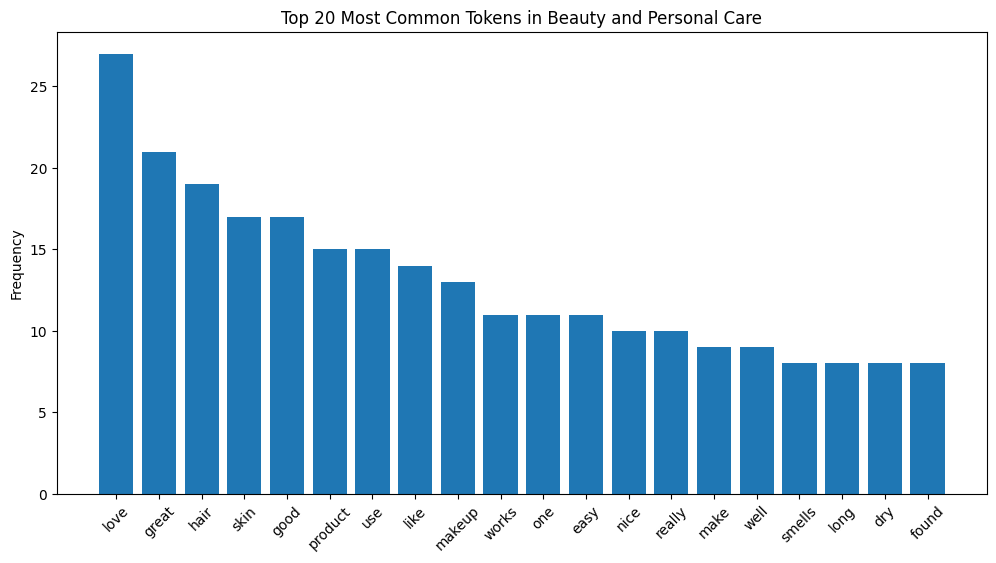

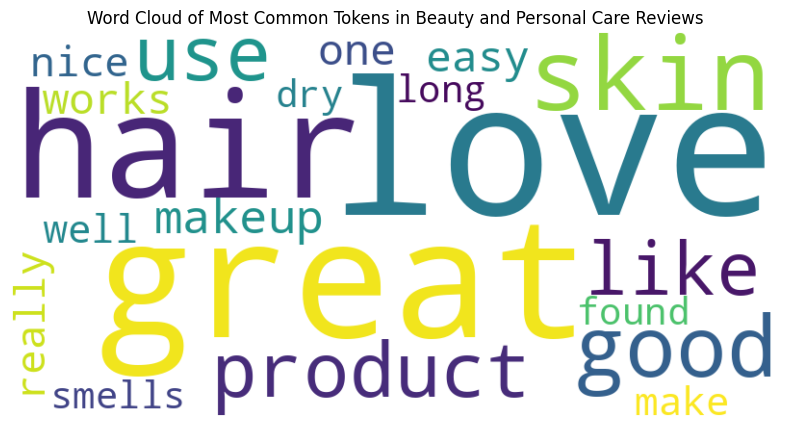

In [ ]:
import matplotlib.pyplot as plt
from datasets import load_dataset
from nltk.corpus import stopwords
import re
import string
from collections import Counter
from wordcloud import WordCloud
import nltk

# Download necessary resources
nltk.download('stopwords')

# Load the sampled dataset
ds = load_dataset("json", data_files="sampled_data.jsonl", split="train")

# Initialize tools
stop_words = set(stopwords.words('english'))
punctuation = string.punctuation

# Preprocess text: remove punctuation, stopwords, and tokenize
def preprocess_text(text):
    # Convert to lowercase and remove punctuation
    text = re.sub(f"[{re.escape(punctuation)}]", "", text.lower())
    # Tokenize by splitting
    tokens = text.split()
    # Remove stopwords
    cleaned_tokens = [token for token in tokens if token not in stop_words]
    return cleaned_tokens

# Preprocess the first 100 reviews
all_tokens = []
for i in range(100):
    tokens = preprocess_text(ds[i]['text'])
    all_tokens.extend(tokens)

# Get the 20 most common tokens
common_tokens = Counter(all_tokens).most_common(20)
tokens, frequencies = zip(*common_tokens)

# Plot 1: Bar plot of the most common tokens
plt.figure(figsize=(12, 6))
plt.bar(tokens, frequencies)
plt.title('Top 20 Most Common Tokens in Beauty and Personal Care')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

# Plot 2: Word cloud of the most common tokens
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(common_tokens))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Tokens in Beauty and Personal Care Reviews')
plt.show()